## Connecting to SLM

In [ ]:
import HEDS
from hedslib.heds_types import *
import sys
import os

# Replace with your actual SDK installation path if different
sdk_install_path = r"C:\Program Files\HOLOEYE Photonics\SLM Display SDK (Python) v4.1.0" # Verify this!
python_api_path = os.path.join(sdk_install_path, "api", "python")

if python_api_path not in sys.path:
    sys.path.append(python_api_path)
    print(f"Added {python_api_path} to Python path.")

# 1. Initialize the SDK
err = HEDS.SDK.Init(4,1) # Using SDK version 4,1
if err != HEDSERR_NoError:
    print(f"Error initializing SDK: {HEDS.SDK.ErrorString(err)}")
    sys.exit() # Use sys.exit() to stop execution
else:
    print("SDK initialized successfully.")

slm = None # Initialize slm to None
try:
    # 2. Initialize an SLM
    # This call will typically open the SLM Device Detection GUI.
    # For automated use, consider using a preselection string like:
    # slm = HEDS.SLM.Init("-slm index:0 -nogui")
    slm = HEDS.SLM.Init()

    # Check if SLM initialization was successful
    if slm.errorCode() != HEDSERR_NoError:
        print(f"Error initializing SLM: {HEDS.SDK.ErrorString(slm.errorCode())}")
        sys.exit()
    else:
        # Access properties directly from the SLM object
        slm_width = slm.width_px() #
        slm_height = slm.height_px() #

        # To get the device name, you typically use the monitor info functions from SDK.libapi
        # Get the SLM window ID from the SLM object
        slm_window_id = slm.window().id() # The SLM object holds a reference to its SLMWindow

        # Get the monitor ID associated with this SLM window
        # The documentation for SDK.PrintMonitorInfos uses heds_info_monitor_get_id_used_slm
        monitor_id_slm = HEDS.SDK.libapi.heds_info_monitor_get_id_used_slm(slm_window_id)

        # Get the name of that monitor/device
        slm_device_name = HEDS.SDK.libapi.heds_info_monitor_get_name(monitor_id_slm)


        print(f"SLM connected successfully: {slm_device_name}")
        print(f"Resolution: {slm_width} x {slm_height}")

        # You can now display images, data, etc.
        # Example: show a blank screen (replace 128 with your desired gray value)
        # slm.showBlankScreen(128)
        # import time
        # time.sleep(5) # Keep it visible for 5 seconds

finally:
    # 3. Close the SLM window when done
    # if slm is not None:
    #     err = slm.window().close() #
    #     if err != HEDSERR_NoError:
    #         print(f"Error closing SLM window: {HEDS.SDK.ErrorString(err)}")
    #     else:
    #         print("SLM window closed.")
    if slm is not None:
        print("SLM Initialization successful. You can now use the SLM for your holography tasks.")
    # It's good practice to also close the SDK


SDK initialized successfully.


AssertionError: "The SLM window could not be opened because the EDID device detection was either cancelled by the user or could not find the preselected SLM."

## Funtion to generate HG mode phasemask

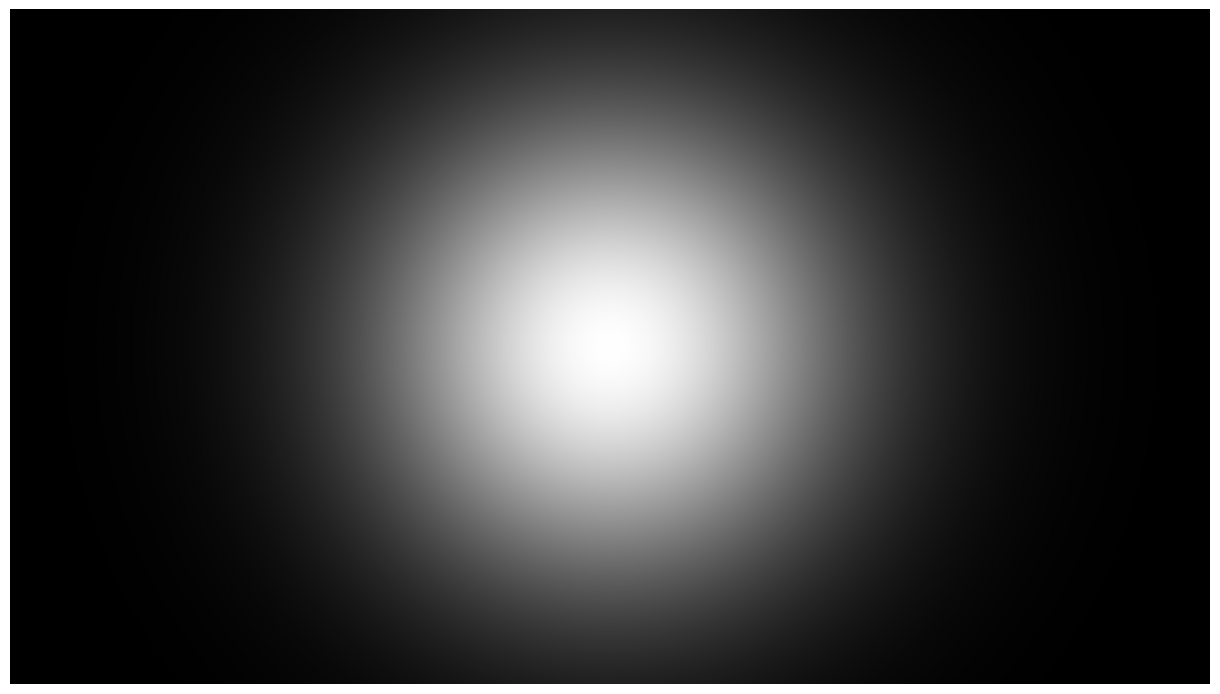

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial
from scipy.io import loadmat
import math

# 1. Initialization and Gaussian Beam Parameters

# %Initializing Hologram Matrices
H = 1920  # Number of Horizontal pixels
V = 1080  # Number of Vertical pixels

# Create 1D coordinate arrays and scale them (in mm)
x_1d = np.arange(-H/2, H/2) * 8e-3
y_1d = np.arange(-V/2, V/2) * 8e-3

# %Meshgrid
# Create 2D coordinate matrices from the scaled 1D arrays
X, Y = np.meshgrid(x_1d, y_1d)

# Calculate polar coordinates
phi = np.angle(X + 1j * Y)
rho = np.sqrt(X**2 + Y**2)

# Define physical constants
lmbda = 633e-6  # Wavelength (in mm)
w0 = 3          # Input beam waist (in mm)
z = 0.00001     # Propagation distance (in mm)

# Calculate derived beam parameters
k = 2 * np.pi / lmbda      # Wavenumber
zr = np.pi * w0**2 / lmbda  # Rayleigh range
w = w0 * np.sqrt(1 + (z / zr)**2)  # Beam radius at distance z
R = z * (1 + (zr / z)**2) if z != 0 else float('inf') # Radius of curvature

# Define Hermite polynomial orders
m = 0
n = 0

# 2. Hermite-Gaussian (HG) Beam and Hologram Generation

# %polyval (HermitePoly(m), ... )
# Get the Hermite polynomial functions from SciPy
hermite_m = hermite(m)
hermite_n = hermite(n)

# Evaluate the polynomials on the grid
Hx = hermite_m(np.sqrt(2) * X / w)
Hy = hermite_n(np.sqrt(2) * Y / w)

# Calculate normalization constant
# Using math.factorial as it's faster for scalars
rc = np.sqrt(2**(1 - n - m) / (np.pi * math.factorial(n) * math.factorial(m))) / w

# Gouy phase term
gouy_phase = (n + m + 1) * np.arctan(z / zr)

# Calculate the complex amplitude of the HG beam
HG = (rc * Hx * Hy *
      np.exp(1j * gouy_phase) *
      np.exp(-rho**2 / w**2) *
      np.exp(-1j * k * rho**2 / (2 * R)) *
      np.exp(1j * k * z))

# %Phase of HG modes
# Normalize the HG field amplitude
HG_abs = np.abs(HG)
HG = HG / np.sqrt(np.sum(HG_abs**2))

# Extract amplitude and phase
ph = np.angle(HG)
A = np.abs(HG)
A = A / np.max(A)  # %Amplitude normalized to unity

# The following lines require the "fx2.mat" file.
# This file contains a lookup table that modifies the beam's amplitude profile.

# --- IMPORTANT ---
# To run this correctly, you need the 'fx2.mat' file.
# Place it in the same directory and uncomment the following line.
# The variable name inside the .mat file is assumed to be 'fx'.

# fx_data = loadmat('fx2.mat')
# fx = fx_data['fx'].flatten() # Flatten to make it a 1D array

# As a placeholder, we create a simple linear mapping.
# Replace this with the actual file loading.
print("Warning: 'fx2.mat' not found. Using a placeholder for the 'fx' array.")
fx = np.linspace(0, 1, 801)
# --- END IMPORTANT ---


# Scale amplitude A to get integer indices for the 'fx' lookup table
# We use np.clip to ensure indices are within the valid range [0, 800]
aux = np.round(A * (len(fx) - 1)).astype(int)
aux = np.clip(aux, 0, len(fx) - 1)

# Apply the amplitude modification using vectorized indexing (replaces the slow loops)
F = fx[aux]

# Define carrier frequency parameters for the grating
nx = 0
ny = 0
V_mm = V * 8e-3  # Total height in mm
H_mm = H * 8e-3  # Total width in mm
gx = nx / H_mm
gy = ny / V_mm

# %SLM
# Modulate the phase with a linear grating and create the final hologram
Hol = F * np.sin(ph + 2 * np.pi * (X * gx + Y * gy))

# Shift hologram values to be non-negative
Hol = Hol - np.min(Hol)

# Normalize the hologram to an 8-bit range [0, 255] for display
SLM = (Hol / np.max(Hol) * 255).astype(np.uint8)


# 3. Displaying the Hologram

# Create a figure to display the SLM pattern
fig, ax = plt.subplots(figsize=(12, 6.75)) # Maintain 16:9 aspect ratio

# Display the hologram image in grayscale
ax.imshow(SLM, cmap='gray')

# Remove axes, ticks, and borders for a clean display
ax.axis('off')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # Fill the entire figure window

# Show the plot
plt.show()

### Function to push 8bit 1920x1080 array to display on SLM

### Moving Center

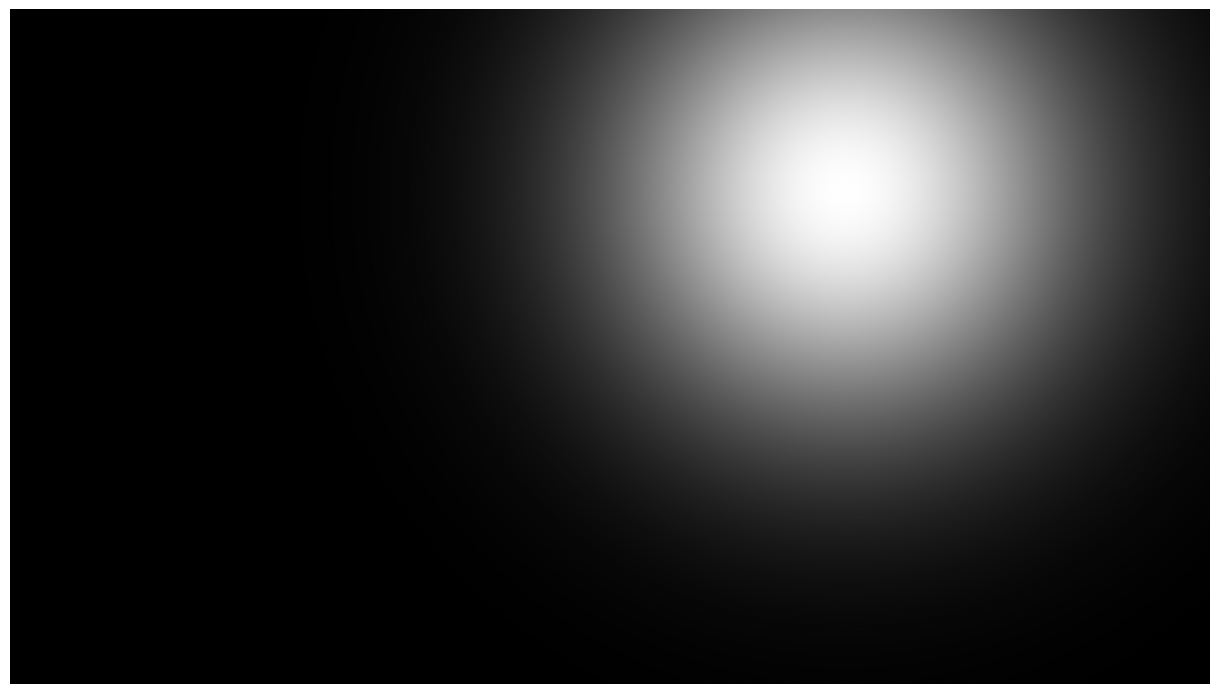

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial
from scipy.io import loadmat
import math

# 1. Initialization and Gaussian Beam Parameters

# %Initializing Hologram Matrices
H = 1920  # Number of Horizontal pixels
V = 1080  # Number of Vertical pixels

# Create 1D coordinate arrays and scale them (in mm)
x_1d = np.arange(-H/2, H/2) * 8e-3
y_1d = np.arange(-V/2, V/2) * 8e-3

# %Meshgrid
# Create 2D coordinate matrices from the scaled 1D arrays
X, Y = np.meshgrid(x_1d, y_1d)

# --- ADD THESE LINES TO SHIFT THE CENTER ---
# Define the desired center coordinates in mm.
# The original center is (0, 0).
x_center = 3.0  # Moves the center 3 mm to the right
y_center = -2.0 # Moves the center 2 mm down

# Redefine the coordinate system relative to the new center
X = X - x_center
Y = Y - y_center
# ------------------------------------------

# Calculate polar coordinates
phi = np.angle(X + 1j * Y)
rho = np.sqrt(X**2 + Y**2)

# Define physical constants
lmbda = 633e-6  # Wavelength (in mm)
w0 = 3          # Input beam waist (in mm)
z = 0.00001     # Propagation distance (in mm)

# Calculate derived beam parameters
k = 2 * np.pi / lmbda      # Wavenumber
zr = np.pi * w0**2 / lmbda  # Rayleigh range
w = w0 * np.sqrt(1 + (z / zr)**2)  # Beam radius at distance z
R = z * (1 + (zr / z)**2) if z != 0 else float('inf') # Radius of curvature

# Define Hermite polynomial orders
m = 0
n = 0

# 2. Hermite-Gaussian (HG) Beam and Hologram Generation

# %polyval (HermitePoly(m), ... )
# Get the Hermite polynomial functions from SciPy
hermite_m = hermite(m)
hermite_n = hermite(n)

# Evaluate the polynomials on the grid
Hx = hermite_m(np.sqrt(2) * X / w)
Hy = hermite_n(np.sqrt(2) * Y / w)

# Calculate normalization constant
# Using math.factorial as it's faster for scalars
rc = np.sqrt(2**(1 - n - m) / (np.pi * math.factorial(n) * math.factorial(m))) / w

# Gouy phase term
gouy_phase = (n + m + 1) * np.arctan(z / zr)

# Calculate the complex amplitude of the HG beam
HG = (rc * Hx * Hy *
      np.exp(1j * gouy_phase) *
      np.exp(-rho**2 / w**2) *
      np.exp(-1j * k * rho**2 / (2 * R)) *
      np.exp(1j * k * z))

# %Phase of HG modes
# Normalize the HG field amplitude
HG_abs = np.abs(HG)
HG = HG / np.sqrt(np.sum(HG_abs**2))

# Extract amplitude and phase
ph = np.angle(HG)
A = np.abs(HG)
A = A / np.max(A)  # %Amplitude normalized to unity

# The following lines require the "fx2.mat" file.
# This file contains a lookup table that modifies the beam's amplitude profile.

# --- IMPORTANT ---
# To run this correctly, you need the 'fx2.mat' file.
# Place it in the same directory and uncomment the following line.
# The variable name inside the .mat file is assumed to be 'fx'.

# fx_data = loadmat('fx2.mat')
# fx = fx_data['fx'].flatten() # Flatten to make it a 1D array

# As a placeholder, we create a simple linear mapping.
# Replace this with the actual file loading.
print("Warning: 'fx2.mat' not found. Using a placeholder for the 'fx' array.")
fx = np.linspace(0, 1, 801)
# --- END IMPORTANT ---


# Scale amplitude A to get integer indices for the 'fx' lookup table
# We use np.clip to ensure indices are within the valid range [0, 800]
aux = np.round(A * (len(fx) - 1)).astype(int)
aux = np.clip(aux, 0, len(fx) - 1)

# Apply the amplitude modification using vectorized indexing (replaces the slow loops)
F = fx[aux]

# Define carrier frequency parameters for the grating
nx = 0
ny = 0
V_mm = V * 8e-3  # Total height in mm
H_mm = H * 8e-3  # Total width in mm
gx = nx / H_mm
gy = ny / V_mm

# %SLM
# Modulate the phase with a linear grating and create the final hologram
Hol = F * np.sin(ph + 2 * np.pi * (X * gx + Y * gy))

# Shift hologram values to be non-negative
Hol = Hol - np.min(Hol)

# Normalize the hologram to an 8-bit range [0, 255] for display
SLM = (Hol / np.max(Hol) * 255).astype(np.uint8)


# 3. Displaying the Hologram

# Create a figure to display the SLM pattern
fig, ax = plt.subplots(figsize=(12, 6.75)) # Maintain 16:9 aspect ratio

# Display the hologram image in grayscale
ax.imshow(SLM, cmap='gray')

# Remove axes, ticks, and borders for a clean display
ax.axis('off')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # Fill the entire figure window

# Show the plot
plt.show()

### Complex Conjugate of the beam

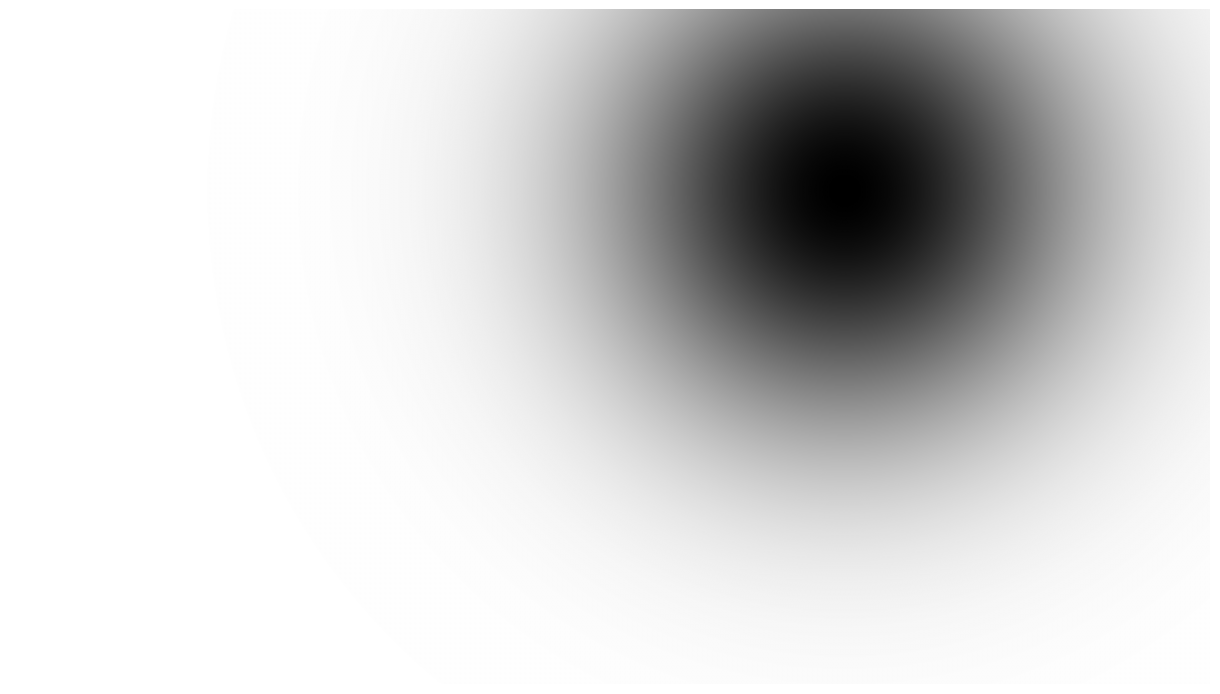

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial
from scipy.io import loadmat
import math

# 1. Initialization and Gaussian Beam Parameters

# %Initializing Hologram Matrices
H = 1920  # Number of Horizontal pixels
V = 1080  # Number of Vertical pixels

# Create 1D coordinate arrays and scale them (in mm)
x_1d = np.arange(-H/2, H/2) * 8e-3
y_1d = np.arange(-V/2, V/2) * 8e-3

# %Meshgrid
# Create 2D coordinate matrices from the scaled 1D arrays
X, Y = np.meshgrid(x_1d, y_1d)

# --- ADD THESE LINES TO SHIFT THE CENTER ---
# Define the desired center coordinates in mm.
# The original center is (0, 0).
x_center = 3.0  # Moves the center 3 mm to the right
y_center = -2.0 # Moves the center 2 mm down

# Redefine the coordinate system relative to the new center
X = X - x_center
Y = Y - y_center
# ------------------------------------------

# Calculate polar coordinates
phi = np.angle(X + 1j * Y)
rho = np.sqrt(X**2 + Y**2)

# Define physical constants
lmbda = 633e-6  # Wavelength (in mm)
w0 = 3          # Input beam waist (in mm)
z = 0.00001     # Propagation distance (in mm)

# Calculate derived beam parameters
k = 2 * np.pi / lmbda      # Wavenumber
zr = np.pi * w0**2 / lmbda  # Rayleigh range
w = w0 * np.sqrt(1 + (z / zr)**2)  # Beam radius at distance z
R = z * (1 + (zr / z)**2) if z != 0 else float('inf') # Radius of curvature

# Define Hermite polynomial orders
m = 0
n = 0

# 2. Hermite-Gaussian (HG) Beam and Hologram Generation

# %polyval (HermitePoly(m), ... )
# Get the Hermite polynomial functions from SciPy
hermite_m = hermite(m)
hermite_n = hermite(n)

# Evaluate the polynomials on the grid
Hx = hermite_m(np.sqrt(2) * X / w)
Hy = hermite_n(np.sqrt(2) * Y / w)

# Calculate normalization constant
# Using math.factorial as it's faster for scalars
rc = np.sqrt(2**(1 - n - m) / (np.pi * math.factorial(n) * math.factorial(m))) / w

# Gouy phase term
gouy_phase = (n + m + 1) * np.arctan(z / zr)

# Calculate the complex amplitude of the HG beam
HG = (rc * Hx * Hy *
      np.exp(1j * gouy_phase) *
      np.exp(-rho**2 / w**2) *
      np.exp(-1j * k * rho**2 / (2 * R)) *
      np.exp(1j * k * z))

# %Phase of HG modes
# Normalize the HG field amplitude
HG = np.conj(HG)  # Complex conjugate of the beam
HG_abs = np.abs(HG)
HG = HG / np.sqrt(np.sum(HG_abs**2))

# Extract amplitude and phase
ph = np.angle(HG)
A = np.abs(HG)
A = A / np.max(A)  # %Amplitude normalized to unity

# The following lines require the "fx2.mat" file.
# This file contains a lookup table that modifies the beam's amplitude profile.

# --- IMPORTANT ---
# To run this correctly, you need the 'fx2.mat' file.
# Place it in the same directory and uncomment the following line.
# The variable name inside the .mat file is assumed to be 'fx'.

# fx_data = loadmat('fx2.mat')
# fx = fx_data['fx'].flatten() # Flatten to make it a 1D array

# As a placeholder, we create a simple linear mapping.
# Replace this with the actual file loading.
print("Warning: 'fx2.mat' not found. Using a placeholder for the 'fx' array.")
fx = np.linspace(0, 1, 801)
# --- END IMPORTANT ---


# Scale amplitude A to get integer indices for the 'fx' lookup table
# We use np.clip to ensure indices are within the valid range [0, 800]
aux = np.round(A * (len(fx) - 1)).astype(int)
aux = np.clip(aux, 0, len(fx) - 1)

# Apply the amplitude modification using vectorized indexing (replaces the slow loops)
F = fx[aux]

# Define carrier frequency parameters for the grating
nx = 0
ny = 0
V_mm = V * 8e-3  # Total height in mm
H_mm = H * 8e-3  # Total width in mm
gx = nx / H_mm
gy = ny / V_mm

# %SLM
# Modulate the phase with a linear grating and create the final hologram
Hol = F * np.sin(ph + 2 * np.pi * (X * gx + Y * gy))

# Shift hologram values to be non-negative
Hol = Hol - np.min(Hol)

# Normalize the hologram to an 8-bit range [0, 255] for display
SLM = (Hol / np.max(Hol) * 255).astype(np.uint8)


# 3. Displaying the Hologram

# Create a figure to display the SLM pattern
fig, ax = plt.subplots(figsize=(12, 6.75)) # Maintain 16:9 aspect ratio

# Display the hologram image in grayscale
ax.imshow(SLM, cmap='gray')

# Remove axes, ticks, and borders for a clean display
ax.axis('off')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # Fill the entire figure window

# Show the plot
plt.show()

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial
from scipy.io import loadmat
import math

def generate_hg_hologram(m, n, w0=1.0, center=(0.0, 0.0), conjugate=False, plot_output=True, Grating = False):
    """
    Generates a hologram for a Hermite-Gaussian (HG) laser beam.

    Args:
        m (int): The order 'm' of the HG mode.
        n (int): The order 'n' of the HG mode.
        w0 (float, optional): The input beam waist (radius) in mm. Defaults to 1.0.
        center (tuple, optional): A tuple (x_center, y_center) for the hologram's
                                  center in mm. Defaults to (0.0, 0.0).
        conjugate (bool, optional): If True, generates the hologram for the complex
                                    conjugate of the beam. Defaults to False.
        plot_output (bool, optional): If True, displays the generated hologram in a plot.
                                      Defaults to True.

    Returns:
        numpy.ndarray: A 2D NumPy array (uint8) representing the final hologram,
                       with values scaled from 0 to 255.
    """
    # 1. Initialization and Grid Setup
    H = 1920  # Number of Horizontal pixels
    V = 1080  # Number of Vertical pixels
    pixel_size = 8e-3 # Pixel size in mm

    # Create 1D coordinate arrays and scale them
    x_1d = np.arange(-H/2, H/2) * pixel_size
    y_1d = np.arange(-V/2, V/2) * pixel_size

    # Create 2D coordinate matrices
    X, Y = np.meshgrid(x_1d, y_1d)

    # Shift the center of the coordinate system based on input
    x_center, y_center = center
    X = X - x_center
    Y = Y - y_center

    # 2. Physical Parameters and Beam Calculation
    # Calculate polar coordinates from the (possibly shifted) grid
    phi = np.angle(X + 1j * Y)
    rho = np.sqrt(X**2 + Y**2)

    # Define physical constants
    lmbda = 633e-6  # Wavelength (in mm)
    z = 0.00001     # Propagation distance (in mm)

    # Calculate derived beam parameters
    k = 2 * np.pi / lmbda      # Wavenumber
    zr = np.pi * w0**2 / lmbda  # Rayleigh range
    w = w0 * np.sqrt(1 + (z / zr)**2)  # Beam radius at distance z
    R = z * (1 + (zr / z)**2) if z != 0 else float('inf') # Radius of curvature

    # Get the Hermite polynomial functions from SciPy
    hermite_m = hermite(m)
    hermite_n = hermite(n)

    # Evaluate the polynomials on the grid
    Hx = hermite_m(np.sqrt(2) * X / w)
    Hy = hermite_n(np.sqrt(2) * Y / w)

    # Calculate normalization constant
    rc = np.sqrt(2**(1 - n - m) / (np.pi * math.factorial(n) * math.factorial(m))) / w

    # Gouy phase term
    gouy_phase = (n + m + 1) * np.arctan(z / zr)

    # Calculate the complex amplitude of the HG beam
    HG = (rc * Hx * Hy *
          np.exp(1j * gouy_phase) *
          np.exp(-rho**2 / w**2) *
          np.exp(-1j * k * rho**2 / (2 * R)) *
          np.exp(1j * k * z))

    # If requested, take the complex conjugate of the beam
    if conjugate:
        HG = np.conj(HG)

    # 3. Hologram Generation
    # Normalize the HG field amplitude
    HG_abs = np.abs(HG)
    HG = HG / np.sqrt(np.sum(HG_abs**2))

    # Extract amplitude and phase
    ph = np.angle(HG)
    A = np.abs(HG)
    A = A / np.max(A)  # Amplitude normalized to unity

    # --- IMPORTANT: fx2.mat handling ---
    # The following attempts to load 'fx2.mat'. If it fails, it creates a
    # placeholder. For accurate results, the real file should be used.
    try:
        fx_data = loadmat('fx2.mat')
        fx = fx_data['fx'].flatten() # Flatten to make it a 1D array
    except FileNotFoundError:
        print("Warning: 'fx2.mat' not found. Using a linear placeholder for 'fx' array.")
        fx = np.linspace(0, 1, 801)
    # ---

    # Scale amplitude A to get integer indices for the 'fx' lookup table
    aux = np.round(A * (len(fx) - 1)).astype(int)
    aux = np.clip(aux, 0, len(fx) - 1)
    F = fx[aux]

    # Define carrier frequency parameters for the grating
    if Grating:
        nx = 50
        ny = 50
    else:
        nx = 0
        ny = 0
    H_mm = H * pixel_size
    V_mm = V * pixel_size
    gx = nx / H_mm
    gy = ny / V_mm

    # Modulate the phase with a linear grating
    Hol = F * np.sin(ph + 2 * np.pi * (X * gx + Y * gy))

    # Shift hologram values to be non-negative
    Hol = Hol - np.min(Hol)

    # Normalize the hologram to an 8-bit range [0, 255] for display
    SLM = (Hol / np.max(Hol) * 255).astype(np.uint8)

    # 4. Plotting
    if plot_output:
        fig, ax = plt.subplots(figsize=(12, 6.75))
        im = ax.imshow(SLM, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'HG({m},{n}), w0={w0}mm, center={center}, conjugate={conjugate}')
        ax.axis('off')
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.show()

    return SLM

# ==============================================================================
# --- EXAMPLE USAGE ---
# ==============================================================================
# if __name__ == '__main__':
#     # Example 1: Generate a standard HG(2,2) mode, centered, and plot it.
#     print("Generating HG(2,2) mode...")
#     hg_2_2_array = generate_hg_hologram(m=2, n=2, w0=1.5)
#     print(f"Returned array shape: {hg_2_2_array.shape}, Data type: {hg_2_2_array.dtype}")
#     print("-" * 30)

#     # Example 2: Generate an HG(5,1) mode with a wider beam, off-center.
#     # This time, we will not plot it, just get the array.
#     print("Generating HG(5,1) mode (no plot)...")
#     center_coords = (3.0, 2.0) # Center at (3mm, 2mm)
#     hg_5_1_array = generate_hg_hologram(m=5, n=1, w0=2.0, center=center_coords, plot_output=False)
#     print(f"Returned array shape: {hg_5_1_array.shape}")
#     # You could now, for example, save this array to a file:
#     # plt.imsave('hg_5_1_hologram.png', hg_5_1_array, cmap='gray')
#     print("-" * 30)

#     # Example 3: Generate the complex conjugate of an HG(1,3) mode and plot it.
#     print("Generating complex conjugate of HG(1,3) mode...")
#     hg_1_3_conj_array = generate_hg_hologram(m=2, n=2, w0=1.2, conjugate=True, plot_output=True)
#     print(f"Returned array shape: {hg_1_3_conj_array.shape}")
#     print("-" * 30)


In [65]:
from HEDS import *
from HEDS import holoeye_slmdisplaysdk_slm as heds
import sys
import numpy

heds.SDK.Init(4,1) # Using SDK version 4,1

# 1. Connect to the SLM and create a preview window.
#    - openPreview=True: This is the default, but we're being explicit here.
#    - previewScale=0.5: This will make the preview window half the size of the SLM's resolution.
slm = heds.SLM.Init(openPreview=True, previewScale=0.5)

# 2. Check for errors
if slm.errorCode() != heds.HEDSERR_NoError:
    print(f"Error connecting to SLM: {heds.SDK.errorString(slm.errorCode())}")
else:
    # 3. If the connection is successful, you can now display data on the SLM.
    #    Here, we'll just show a blank screen.
    slm.showBlankScreen(000) # Show a mid-gray screen

    # 4. The script will wait here until you close the SLM window or the preview window.
    

In [ ]:
slm.showImageData(generate_hg_hologram(m=2, n=2, w0=1, center=(0.0, 0.0), conjugate=True, plot_output=False, Grating=True))

0

In [63]:
import time
X = np.linspace(0.1, 3, 53)
for x in X:
    slm.showImageData(generate_hg_hologram(m=0, n=0, w0=x, center=(0.0, 0.0), conjugate=False, plot_output=False, Grating=False))
    time.sleep(0.1)

KeyboardInterrupt: 

In [71]:
slm.showImageData(generate_hg_hologram(m=1, n=1, w0=3, center=(0.0, 0.0), conjugate=True, plot_output=False, Grating=True))

0

In [75]:
x = np.linspace(-3, 3, 10)
y = np.linspace(-3, 3, 10)

for Y in y:
    for X in x:
        slm.showImageData(generate_hg_hologram(m=2, n=2, w0=3, center=(X, Y), conjugate=False, plot_output=False, Grating=True))
        time.sleep(0.1)

KeyboardInterrupt: 

In [ ]:
err, dh = slm.loadImageData(generate_hg_hologram(m=2, n=2, w0=1, center=(0.0, 0.0), conjugate=True, plot_output=False, Grating=True))

In [ ]:
bm = HEDS.BeamManipulation( 0.0, 0.0, 0.0, 0, 0.0, 0.0, None, dh)
bm.setBeamSteerXDegree(2.27)
bm.setBeamSteerYDegree(-0.388)
bm.setBeamLensFocalLengthMM(100)

In [ ]:
dh.setBeamManipulation(bm)

In [ ]:
dh.apply()